https://mp.weixin.qq.com/s/X_LSll_u-KmD4Wd2Se9LWA
    
https://github.com/chiphuyen/machine-learning-systems-design

# 系统设计
这个词对于我而言，一直有很大的魔力。

系统，我的理解，就是一个(组)tasks闭环，接收一些指定格式的输入和参数设置，然后就可以一直运行到任务终结

# Machine Learning Systems Design
第二部分是这本书的核心内容，即如何设计一个机器学习系统。作者将这一设计过程分为四步：项目设置、数据 pipeline、建模（选择、训练和调试模型）和服务（测试、部署和维护模型）。

This booklet covers four main steps of designing a machine learning system:
* Project setup
* Data pipeline
* Modeling: selecting, training, and debugging
* Serving: testing, deploying, and maintaining

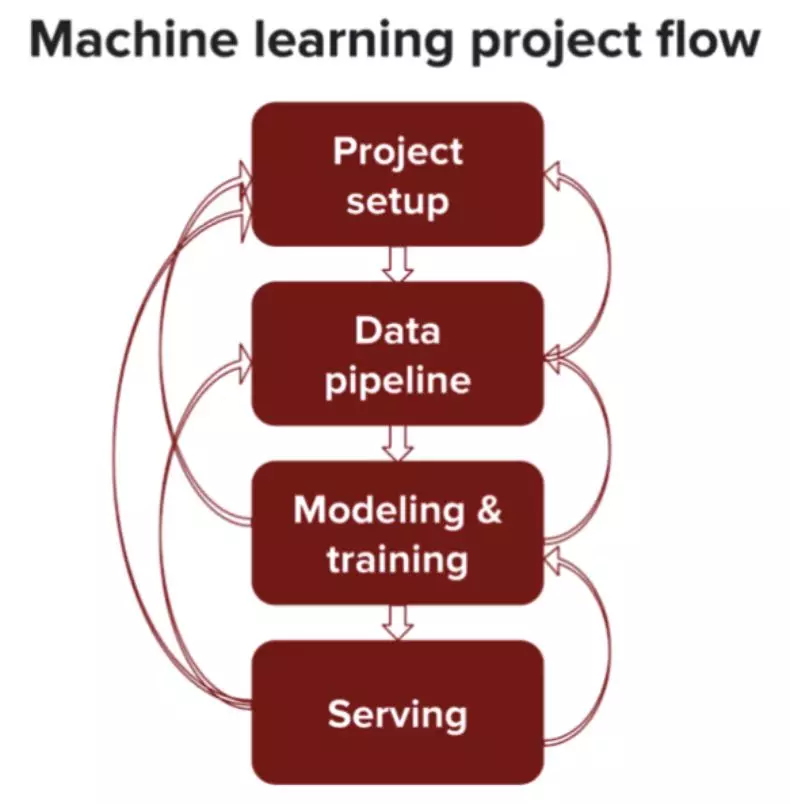

# SparkML框架解析
http://spark.apache.org/docs/latest/ml-pipeline.html

## Main concepts in Pipelines

MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow. This section covers the key concepts introduced by the Pipelines API, where the pipeline concept is mostly inspired by the scikit-learn project.

* __DataFrame__: ml使用的数据结构。This ML API uses DataFrame from Spark SQL as an ML dataset, which can hold a variety of data types. E.g., a DataFrame could have different columns storing text, feature vectors, true labels, and predictions.

* __Transformer__: 输入一个df，输出另外一个df。A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.   
Technically, a Transformer implements a method `transform()`, which converts one DataFrame into another  
transformer包含两类：
    * feature transformers
    * learned models

* __Estimator__: fit一个df，输出一个__Transformer__。An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model.

* __Pipeline__: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.

* __Parameter__: All Transformers and Estimators now share a common API for specifying parameters.


__Transformer.transform()s and Estimator.fit()s are both stateless__. 

__Each instance of a Transformer or Estimator has a unique ID, which is useful in specifying parameters__

## How it works

A Pipeline is specified as __a sequence of stages__, and each stage is either a Transformer or an Estimator. These stages are run __in order__, and the input DataFrame is transformed as it passes through each stage. For Transformer stages, the transform() method is called on the DataFrame. For Estimator stages, the fit() method is called to produce a Transformer (which becomes part of the PipelineModel, or fitted Pipeline), and that Transformer’s transform() method is called on the DataFrame.

We illustrate this for the simple text document workflow. The figure below is for the training time usage of a Pipeline.
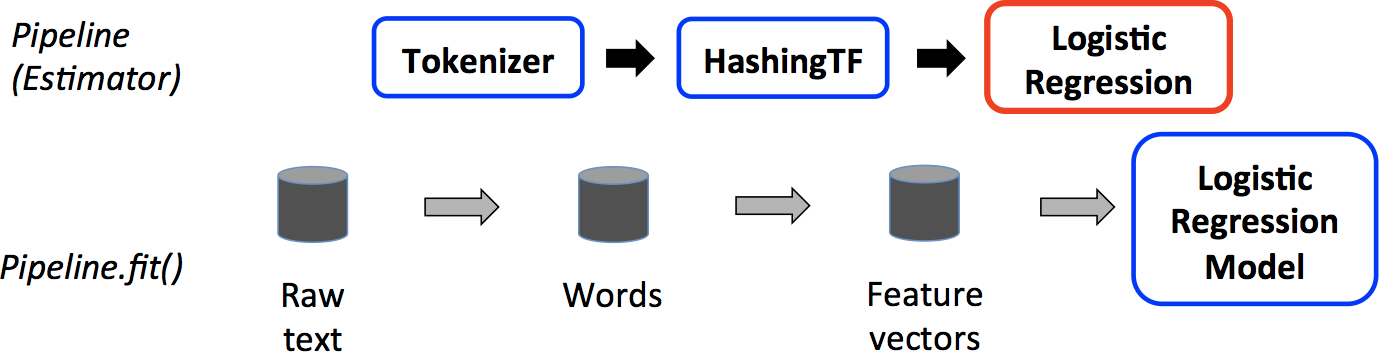

A Pipeline is an Estimator. Thus, after a Pipeline’s fit() method runs, it produces a PipelineModel, which is a Transformer. This PipelineModel is used at test time; the figure below illustrates this usage.



Pipelines and PipelineModels help to ensure that training and test data go through identical feature processing steps.
Details

### Details

DAG Pipelines: A Pipeline’s stages are specified as an ordered array. The examples given here are all for linear Pipelines, i.e., Pipelines in which each stage uses data produced by the previous stage. It is possible to create non-linear Pipelines as long as the data flow graph forms a Directed Acyclic Graph (DAG). This graph is currently specified implicitly based on the input and output column names of each stage (generally specified as parameters). If the Pipeline forms a DAG, then the stages must be specified in topological order.

## 示例

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

# sklearn中的pipeline
https://scikit-learn.org/stable/modules/compose.html

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

* Convenience and encapsulation  
    You only have to call fit and predict once on your data to fit a whole sequence of estimators.
* Joint parameter selection  
    You can grid search over parameters of all estimators in the pipeline at once.
* Safety  
    Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

## Usage
### Construction

The Pipeline is built using a list of (key, value) pairs, where the key is a string containing the name you want to give this step and value is an estimator object:



In [2]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe 

/Users/luoyonggui/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/luoyonggui/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Pipeline(memory=None,
         steps=[('reduce_dim',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

The utility function make_pipeline is a shorthand for constructing pipelines; it takes a variable number of estimators and returns a pipeline, filling in the names automatically:

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
make_pipeline(Binarizer(), MultinomialNB()) 

Pipeline(memory=None,
         steps=[('binarizer', Binarizer(copy=True, threshold=0.0)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Accessing steps

The estimators of a pipeline are stored as a list in the steps attribute, but can be accessed by index or name by indexing (with [idx]) the Pipeline:

In [4]:
pipe.steps[0] 

('reduce_dim',
 PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False))

In [5]:
pipe[0] 

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [6]:
pipe['reduce_dim']

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### Notes

Calling fit on the pipeline is the same as calling fit on each estimator in turn, transform the input and pass it on to the next step. 

The pipeline has all the methods that the last estimator in the pipeline has, i.e. if the last estimator is a classifier, the Pipeline can be used as a classifier. If the last estimator is a transformer, again, so is the pipeline.

# End-to-End Machine Learning Project
[Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) chapter 2

In this chapter, you will go through an example project end to end, pretending to be a recently hired data scientist in a real estate company. Here are the main steps you will go through:
1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.
## Working with Real Data
When you are learning about Machine Learning it is best to actually experiment with real-world data, not just artificial datasets. Fortunately, there are thousands of open datasets to choose from, ranging across all sorts of domains. Here are a few places you can look to get data:

• Popular open data repositories:

In this chapter we chose the California Housing Prices dataset from the StatLib repos‐ itory2 (see Figure 2-1). This dataset was based on data from the 1990 California census. It is not exactly recent (you could still afford a nice house in the Bay Area at the time), but it has many qualities for learning, so we will pretend it is recent data. We also added a categorical attribute and removed a few features for teaching purposes.
## Look at the Big Picture
Download from finelybook www.finelybook.com

Welcome to Machine Learning Housing Corporation! The first task you are asked to perform is to build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short.
Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

Since you are a well-organized data scientist, the first thing you do is to pull out your Machine Learning project checklist. You can start with the one in Appendix B; it should work reasonably well for most Machine Learning projects but make sure to adapt it to your needs. In this chapter we will go through many checklist items, but we will also skip a few, either because they are self- explanatory or because they will be discussed in later chapters.

### Frame the Problem
The first question to ask your boss is what exactly is the business objective; building a model is probably not the end goal. How does the company expect to use and benefit from this model? This is important because it will determine how you frame the problem, what algorithms you will select, what performance measure you will use to evaluate your model, and how much effort you should spend tweaking it.
Your boss answers that your model’s output (a prediction of a district’s median hous‐ ing price) will be fed to another Machine Learning system (see Figure 2-2), along with many other signals.3 This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects reve‐ nue.
#### Pipelines
A sequence of data processing components is called a data pipeline. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply.
Components typically run asynchronously. Each component pulls in a large amount of data, processes it, and spits out the result in another data store, and then some time later the next component in the pipeline pulls this data and spits out its own output, and so on. Each component is fairly self-contained: the interface between components is simply the data store. This makes the system quite simple to grasp (with the help of a data flow graph), and different teams can focus on different components. Moreover, if a component breaks down, the downstream components can often continue to run normally (at least for a while) by just using the last output from the broken compo‐ nent. This makes the architecture quite robust.
On the other hand, a broken component can go unnoticed for some time if proper monitoring is not implemented. The data gets stale and the overall system’s perfor‐ mance drops.

The next question to ask is what the current solution looks like (if any). It will often give you a reference performance, as well as insights on how to solve the problem. Your boss answers that the district housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district (excluding median housing prices), and they use complex rules to come up with an estimate. This is costly and time-consuming, and their estimates are not great; their typical error rate is about 15%.
Okay, with all this information you are now ready to start designing your system. First, you need to frame the problem: is it supervised, unsupervised, or Reinforce‐ ment Learning? Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques? Before you read on, pause and try to answer these questions for yourself.
Have you found the answers? Let’s see: it is clearly a typical supervised learning task since you are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price). Moreover, it is also a typical regres‐ sion task, since you are asked to predict a value. More specifically, this is a multivari‐ ate regression problem since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.). In the first chapter, you predicted life satisfaction based on just one feature, the GDP per capita, so it was a univariate regression problem. Finally, there is no continuous flow of data coming in the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.
If the data was huge, you could either split your batch learning work across multiple servers (using the MapReduce technique, as we will see later), or you could use an online learning technique instead.

### Select a Performance Measure
Your next step is to select a performance measure. A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It measures the standard deviation4 of the errors the system makes in its predictions. For example, an RMSE equal to 50,000 means that about 68% of the system’s predictions fall within $50,000 of the actual value, and about 95% of the predictions fall within $100,000 of the actual value.5 Equation 2-1 shows the mathematical formula to compute the RMSE.
### Check the Assumptions
Lastly, it is good practice to list and verify the assumptions that were made so far (by you or others); this can catch serious issues early on. For example, the district prices that your system outputs are going to be fed into a downstream Machine Learning system, and we assume that these prices are going to be used as such. But what if the downstream system actually converts the prices into categories (e.g., “cheap,” “medium,” or “expensive”) and then uses those categories instead of the prices them‐ selves? In this case, getting the price perfectly right is not important at all; your sys‐ tem just needs to get the category right. If that’s so, then the problem should have been framed as a classification task, not a regression task. You don’t want to find this out after working on a regression system for months.
Fortunately, after talking with the team in charge of the downstream system, you are confident that they do indeed need the actual prices, not just categories. Great! You’re all set, the lights are green, and you can start coding now!